# 2nd Level Model Structure: Condenser Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.model_utility import add_dual, update_dual, check_DOF
from utility.display_utility import trans_product_mole, trans_product_mass

# stage construction rules
from physics.energy.energy_condenser import energy_block_rule
from physics.VLE.VLLE_condenser import VLLE_block_rule

# collect variable bounds
from physics.bounds import water_x, water_yp

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet
model.COMP_WATER = pe.Set(initialize=['H2O'])

# Global Variables

In [4]:
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(20+273.15,40+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar
model.Q_main = pe.Var(within=pe.Reals) # MW
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.W = pe.Var(within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)

model.H_F = pe.Var(within=pe.Reals)
model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

# Construct Individual Blocks

In [5]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [6]:
model.VLE_block = pe.Block(rule=VLLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [7]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    elif i in model.COMP_WATER:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) - model.W == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [8]:
# Equilibrium
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL-model.COMP_WATER,rule=VL_equil_rule)

# Water phase
def L_water_rule(model,i):
    return model.x[i] == pe.exp(-0.66037 - 7.1130*(539.1/model.T) - 0.67885*(1-model.T/539.1)**(1/3) -1.43381*(1-model.T/539.1))
model.L_water_con = pe.Constraint(model.COMP_WATER,rule=L_water_rule)

def V_water_rule(model,i):
    return model.y[i]*model.P == pe.exp(2.30258509299*(5.20389 - 1733.926/(model.T-39.485)))
model.V_water_con = pe.Constraint(model.COMP_WATER,rule=V_water_rule)

In [9]:
# add bounds specifically for water
model.x['H2O'].setub(water_x[1]+abs(water_x[1])*0.1)
model.x['H2O'].setlb(water_x[0]-abs(water_x[0])*0.1)

model.y['H2O'].setub(water_yp[1]/model.P.lb)
model.y['H2O'].setlb(water_yp[0]/model.P.ub)

## Summation

\begin{equation}
\sum_ix_{i} = 1 \\
\sum_iy_{i} = 1
\end{equation}

In [10]:
def summation_x_main_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == 1
model.summation_x_main_con = pe.Constraint(rule=summation_x_main_rule)

def summation_y_main_rule(model):
    return sum(model.y[i] for i in m.COMP_TOTAL) == 1
model.summation_y_main_con = pe.Constraint(rule=summation_y_main_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [11]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) - model.W*model.energy_block.dH_L['H2O'] == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [12]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Load a sample vapor feed from reactive flash example

In [13]:
with open('../saved_solutions/reactive_flash_MPCC_P_pf_200C.pickle', 'rb') as f:
    C200 = pickle.load(f)

## Fixing In/Product Redundent Flow

In [14]:
model.x_.fix(0)
for i in m.COMP_TOTAL:
    model.y_['in',i].fix(C200.Solution.Variable['y[{}]'.format(i)]['Value'])
model.L['in'].fix(0)
model.L['out'].fix(0)
model.V['in'].fix(1)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(C200.Solution.Variable['H_V']['Value'])

## Fixing Model Parameters

In [15]:
model.P.fix(19)
model.T_F.fix(200+273.15)
model.F.fix(0)
model.z.fix(0)
model.VLE_block.n_ave.fix(4)

In [16]:
check_DOF(pe,model)

Active Equality Constraints:	 957
Active Inequality Constraints:	 0
Active Variables:		 1129
Fixed Variables:		 171
DOF:				 1


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [17]:
model.T.setub(30+273.15)

In [18]:
model.obj = pe.Objective(expr = model.T,sense=pe.maximize)

In [19]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'
# opt.options['nlp_scaling_method'] = None
# opt.options['bound_relax_factor'] = 0

opt.options['halt_on_ampl_error'] = 'yes'
opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
halt_on_ampl_error=yes
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     3065
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in 


Number of Iterations....: 123

                                   (scaled)                 (unscaled)
Objective...............:  -3.0315000302899409e+02   -3.0315000302899409e+02
Dual infeasibility......:   9.4422358820622776e-11    9.4422358820622776e-11
Constraint violation....:   4.9976037414314889e-11    4.9976037414314889e-11
Complementarity.........:   2.5059047139809497e-09    2.5059047139809497e-09
Overall NLP error.......:   2.5059047139809497e-09    2.5059047139809497e-09


Number of objective function evaluations             = 183
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 183
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 134
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 123
Total CPU secs in IPOPT (w/o function evaluations)   =      1.197
Total CPU secs in NLP function evalu

In [20]:
model.Q_main.value

-11.949299628754689

In [21]:
model.T.value

303.15

In [22]:
# model.solutions.store_to(results)
# with open('../saved_solutions/condenser_MPCC_P_pf_30C.pickle','wb') as f1:
#     pickle.dump(results,f1)

In [23]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0000			Vapor: 0.8693			log K
------------------------------------------------------------------------------------------------------------
H2         		 0.3830%			29.0921%			1.8805
CO         		 0.9322%			32.9988%			1.5490
CO2        		 7.1077%			36.5818%			0.7115
H2O        		 0.0001%			 0.2233%			3.6256
C2H4       		 0.0420%			 0.1346%			0.5054
C3H6       		 0.2557%			 0.1529%			-0.2233
C4H8       		 0.7110%			 0.1315%			-0.7330
C5H10      		 1.6751%			 0.0905%			-1.2674
C6H12      		 3.7739%			 0.0622%			-1.7830
C7H14      		 6.1060%			 0.0316%			-2.2866
C8H16      		 7.2897%			 0.0120%			-2.7821
C9H18      		 7.2806%			 0.0039%			-3.2716
C10H20     		 6.6672%			 0.0012%			-3.7565
C11H22     		 3.6980%			 0.0002%			-4.2378
C12H24     		 3.0845%			 0.0001%			-4.7163
C13H26     		 2.4624%			 0.0000%			-5.1924
C14H28     		 1.8782%			 0.0000%			-5.6666
C15H30     		 1.3704%			 0.0000%			-6.1391
C16H32     		 0.9610%			 0.0000%			-6.6103
C17H34     		 0.6523%			 0.00

# Iterative Solve for Data Analysis

In [24]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [25]:
cd_data = {}
cd_data['x'] = {}; cd_data['T'] = []; cd_data['Q'] = []; cd_data['V'] = []; cd_data['L'] = []; 

for i in m.COMP_TOTAL:
    cd_data['x'][i] = []
    
Trange = np.arange(40+273.15,19+273.15,-2)

for Tub in Trange:
    model.T.setub(Tub)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    # print('-'*72)
    print('Solved, Solution T = {} K'.format(model.T.value))
    # print('-'*72)
    cd_data['T'].append(model.T.value)
    cd_data['Q'].append(model.Q_main.value)
    cd_data['V'].append(model.V['out'].value)
    cd_data['L'].append(model.L['out'].value)    

    for i in m.COMP_TOTAL:
        cd_data['x'][i].append(model.x[i].value*model.L['out'].value)

Solved, Solution T = 313.15 K
Solved, Solution T = 311.15 K
Solved, Solution T = 309.15 K
Solved, Solution T = 307.15 K
Solved, Solution T = 305.15 K
Solved, Solution T = 303.15 K
Solved, Solution T = 301.15 K
Solved, Solution T = 299.15 K
Solved, Solution T = 297.15 K
Solved, Solution T = 295.15 K
Solved, Solution T = 293.15 K


## Some Observations

* This system has multiple solution under same Q.
* The reaction rate peaks at ~530K, due to decreasing $\alpha$, increasing light component, uses up more feed.
* Note that when 'fully' utilizing catalyst, the system seems to always require cooling.

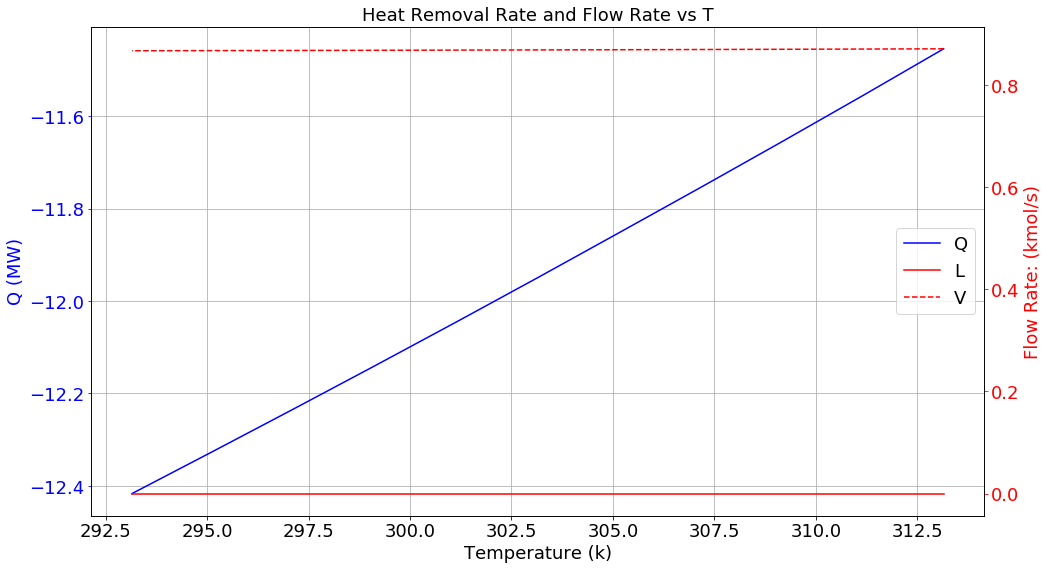

In [26]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(cd_data['T'],cd_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(cd_data['T'],cd_data['L'], 'r')
line3 = ax2.plot(cd_data['T'],cd_data['V'], 'r--')
ax2.set_ylabel('Flow Rate: (kmol/s)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3,['Q','L','V'],fontsize=18,loc=5)
ax1.set_title('Heat Removal Rate and Flow Rate vs T',fontsize=18)
plt.show()

## Product Distribution (mole)

In [27]:
reaction_data = trans_product_mole(cd_data['x'])['unscaled']
reaction_data_scaled = trans_product_mole(cd_data['x'])['scaled']

/Users/steven/Documents/GitHub/FT-Reactive-Distillation-Pyomo/utility/display_utility.py:54: RuntimeWarning: divide by zero encountered in true_divide
  scale_factor = 1/sum(dataset_scaled[i] for i in dataset_scaled.keys())
/Users/steven/Documents/GitHub/FT-Reactive-Distillation-Pyomo/utility/display_utility.py:56: RuntimeWarning: invalid value encountered in multiply
  dataset_scaled[i] = dataset_scaled[i]*scale_factor


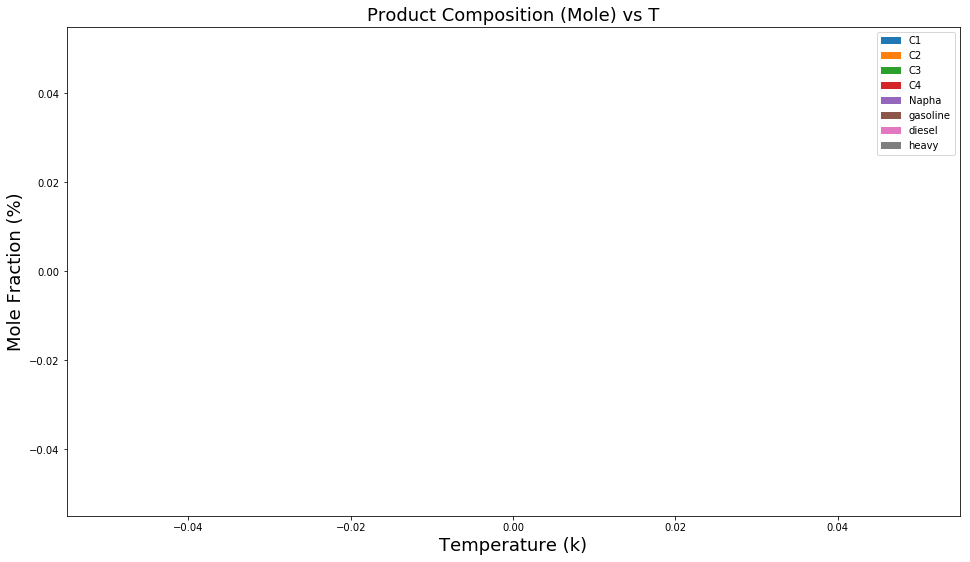

In [28]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(cd_data['T'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

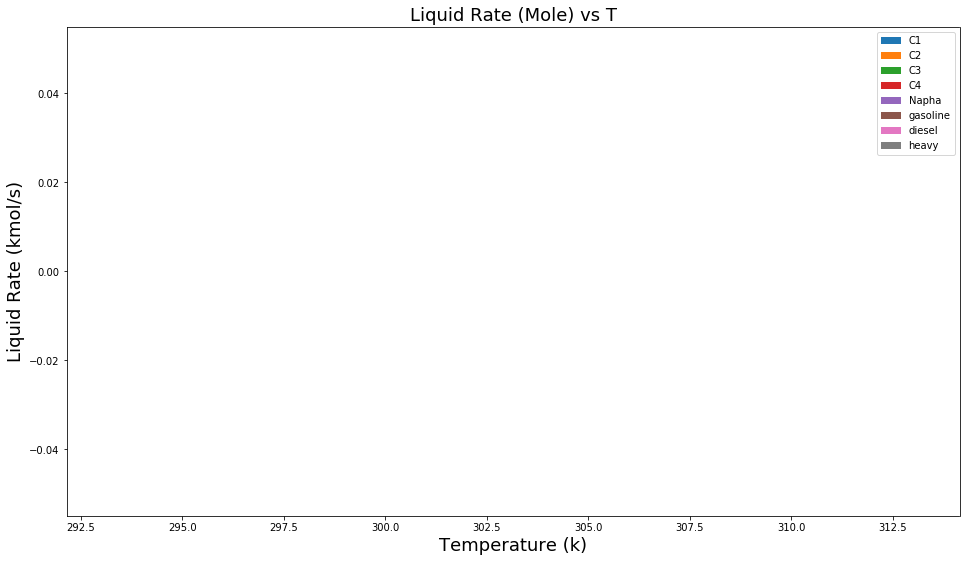

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(cd_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Liquid Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Liquid Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

## Product Distribution (mass)

In [30]:
mass_reaction_data = trans_product_mass(cd_data['x'])['unscaled']
mass_reaction_scaled = trans_product_mass(cd_data['x'])['scaled']

/Users/steven/Documents/GitHub/FT-Reactive-Distillation-Pyomo/utility/display_utility.py:54: RuntimeWarning: divide by zero encountered in true_divide
  scale_factor = 1/sum(dataset_scaled[i] for i in dataset_scaled.keys())
/Users/steven/Documents/GitHub/FT-Reactive-Distillation-Pyomo/utility/display_utility.py:56: RuntimeWarning: invalid value encountered in multiply
  dataset_scaled[i] = dataset_scaled[i]*scale_factor


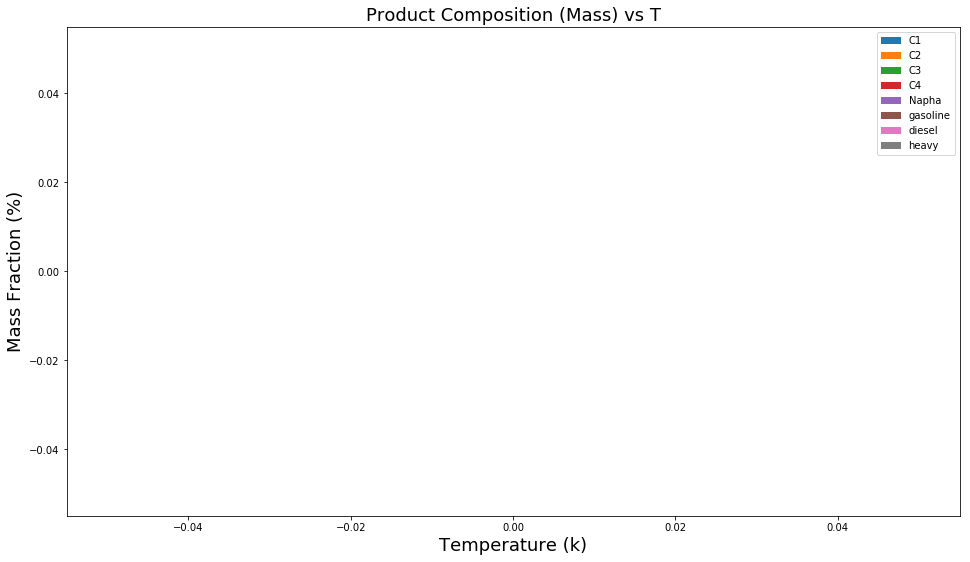

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(cd_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

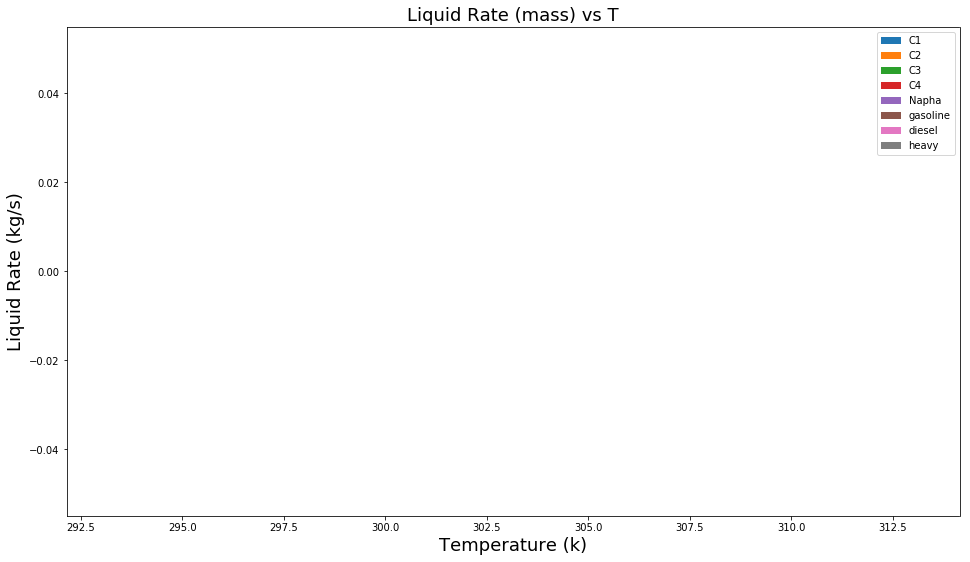

In [32]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(cd_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Liquid Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Liquid Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [33]:
# model.solutions.store_to(results)
# with open('../saved_solutions/condenser_20C.pickle','wb') as f:
#     pickle.dump(results,f)

In [34]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0000			Vapor: 0.8677			log K
------------------------------------------------------------------------------------------------------------
H2         		 0.3672%			29.1468%			1.8997
CO         		 0.9247%			33.0603%			1.5533
CO2        		 7.8956%			36.6361%			0.6665
H2O        		 0.0000%			 0.1229%			3.5684
C2H4       		 0.0481%			 0.1347%			0.4476
C3H6       		 0.3212%			 0.1523%			-0.3241
C4H8       		 0.9428%			 0.1286%			-0.8651
C5H10      		 2.2577%			 0.0829%			-1.4350
C6H12      		 4.7312%			 0.0487%			-1.9876
C7H14      		 6.7026%			 0.0198%			-2.5291
C8H16      		 7.2340%			 0.0063%			-3.0631
C9H18      		 6.8854%			 0.0018%			-3.5915
C10H20     		 6.1882%			 0.0005%			-4.1158
C11H22     		 3.4091%			 0.0001%			-4.6367
C12H24     		 2.8366%			 0.0000%			-5.1550
C13H26     		 2.2626%			 0.0000%			-5.6711
C14H28     		 1.7253%			 0.0000%			-6.1854
C15H30     		 1.2587%			 0.0000%			-6.6982
C16H32     		 0.8826%			 0.0000%			-7.2097
C17H34     		 0.5991%			 0.00

In [35]:
from utility.data_utility import cal_MW

In [36]:
liquid_MW = 0
for i in m.COMP_TOTAL:
    liquid_MW += model.x[i].value*cal_MW(i)

In [37]:
model.L['out'].value*liquid_MW

0.0

In [38]:
liquid_MW

130.5663825551792